In [1]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir a semente para reprodução dos resultados
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


2025-06-04 11:41:36.260141: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 11:41:36.267799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749048096.276739 2418336 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749048096.279339 2418336 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 11:41:36.288714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
#Leitura de dados
df = pd.read_csv('../data_per_month.csv')

In [3]:
data = df.copy()

train_size = int(len(data) * 0.8)  # 80% treino, 20% teste
train, test = data[:train_size], data[train_size:]

In [4]:
from statsmodels.tsa.stattools import adfuller

# Executar o teste ADF na série original
result = adfuller(train['Total Renewable Energy'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Transformação Logarítmica
train = train.copy()
train.loc[:, 'Log'] = np.log(train['Total Renewable Energy'])
# Verificando a série transformada
print(train)

ADF Statistic: -0.89730517477791
p-value: 0.7888585668091626
     Year  Month  Day  Total Renewable Energy   Data Time       Log
0    1973      1   26                 219.840  1973-01-26  5.392900
1    1973      2   26                 197.330  1973-02-26  5.284877
2    1973      3   26                 218.687  1973-03-26  5.387641
3    1973      4   26                 209.330  1973-04-26  5.343912
4    1973      5   26                 215.982  1973-05-26  5.375195
..    ...    ...  ...                     ...         ...       ...
485  2013      6   26                 457.129  2013-06-26  6.124966
486  2013      7   26                 462.057  2013-07-26  6.135688
487  2013      8   26                 434.547  2013-08-26  6.074304
488  2013      9   26                 408.686  2013-09-26  6.012947
489  2013     10   26                 428.271  2013-10-26  6.059756

[490 rows x 6 columns]


1
0
0
ADF Statistic: -6.1427127992825366
p-value: 7.900331345240156e-08


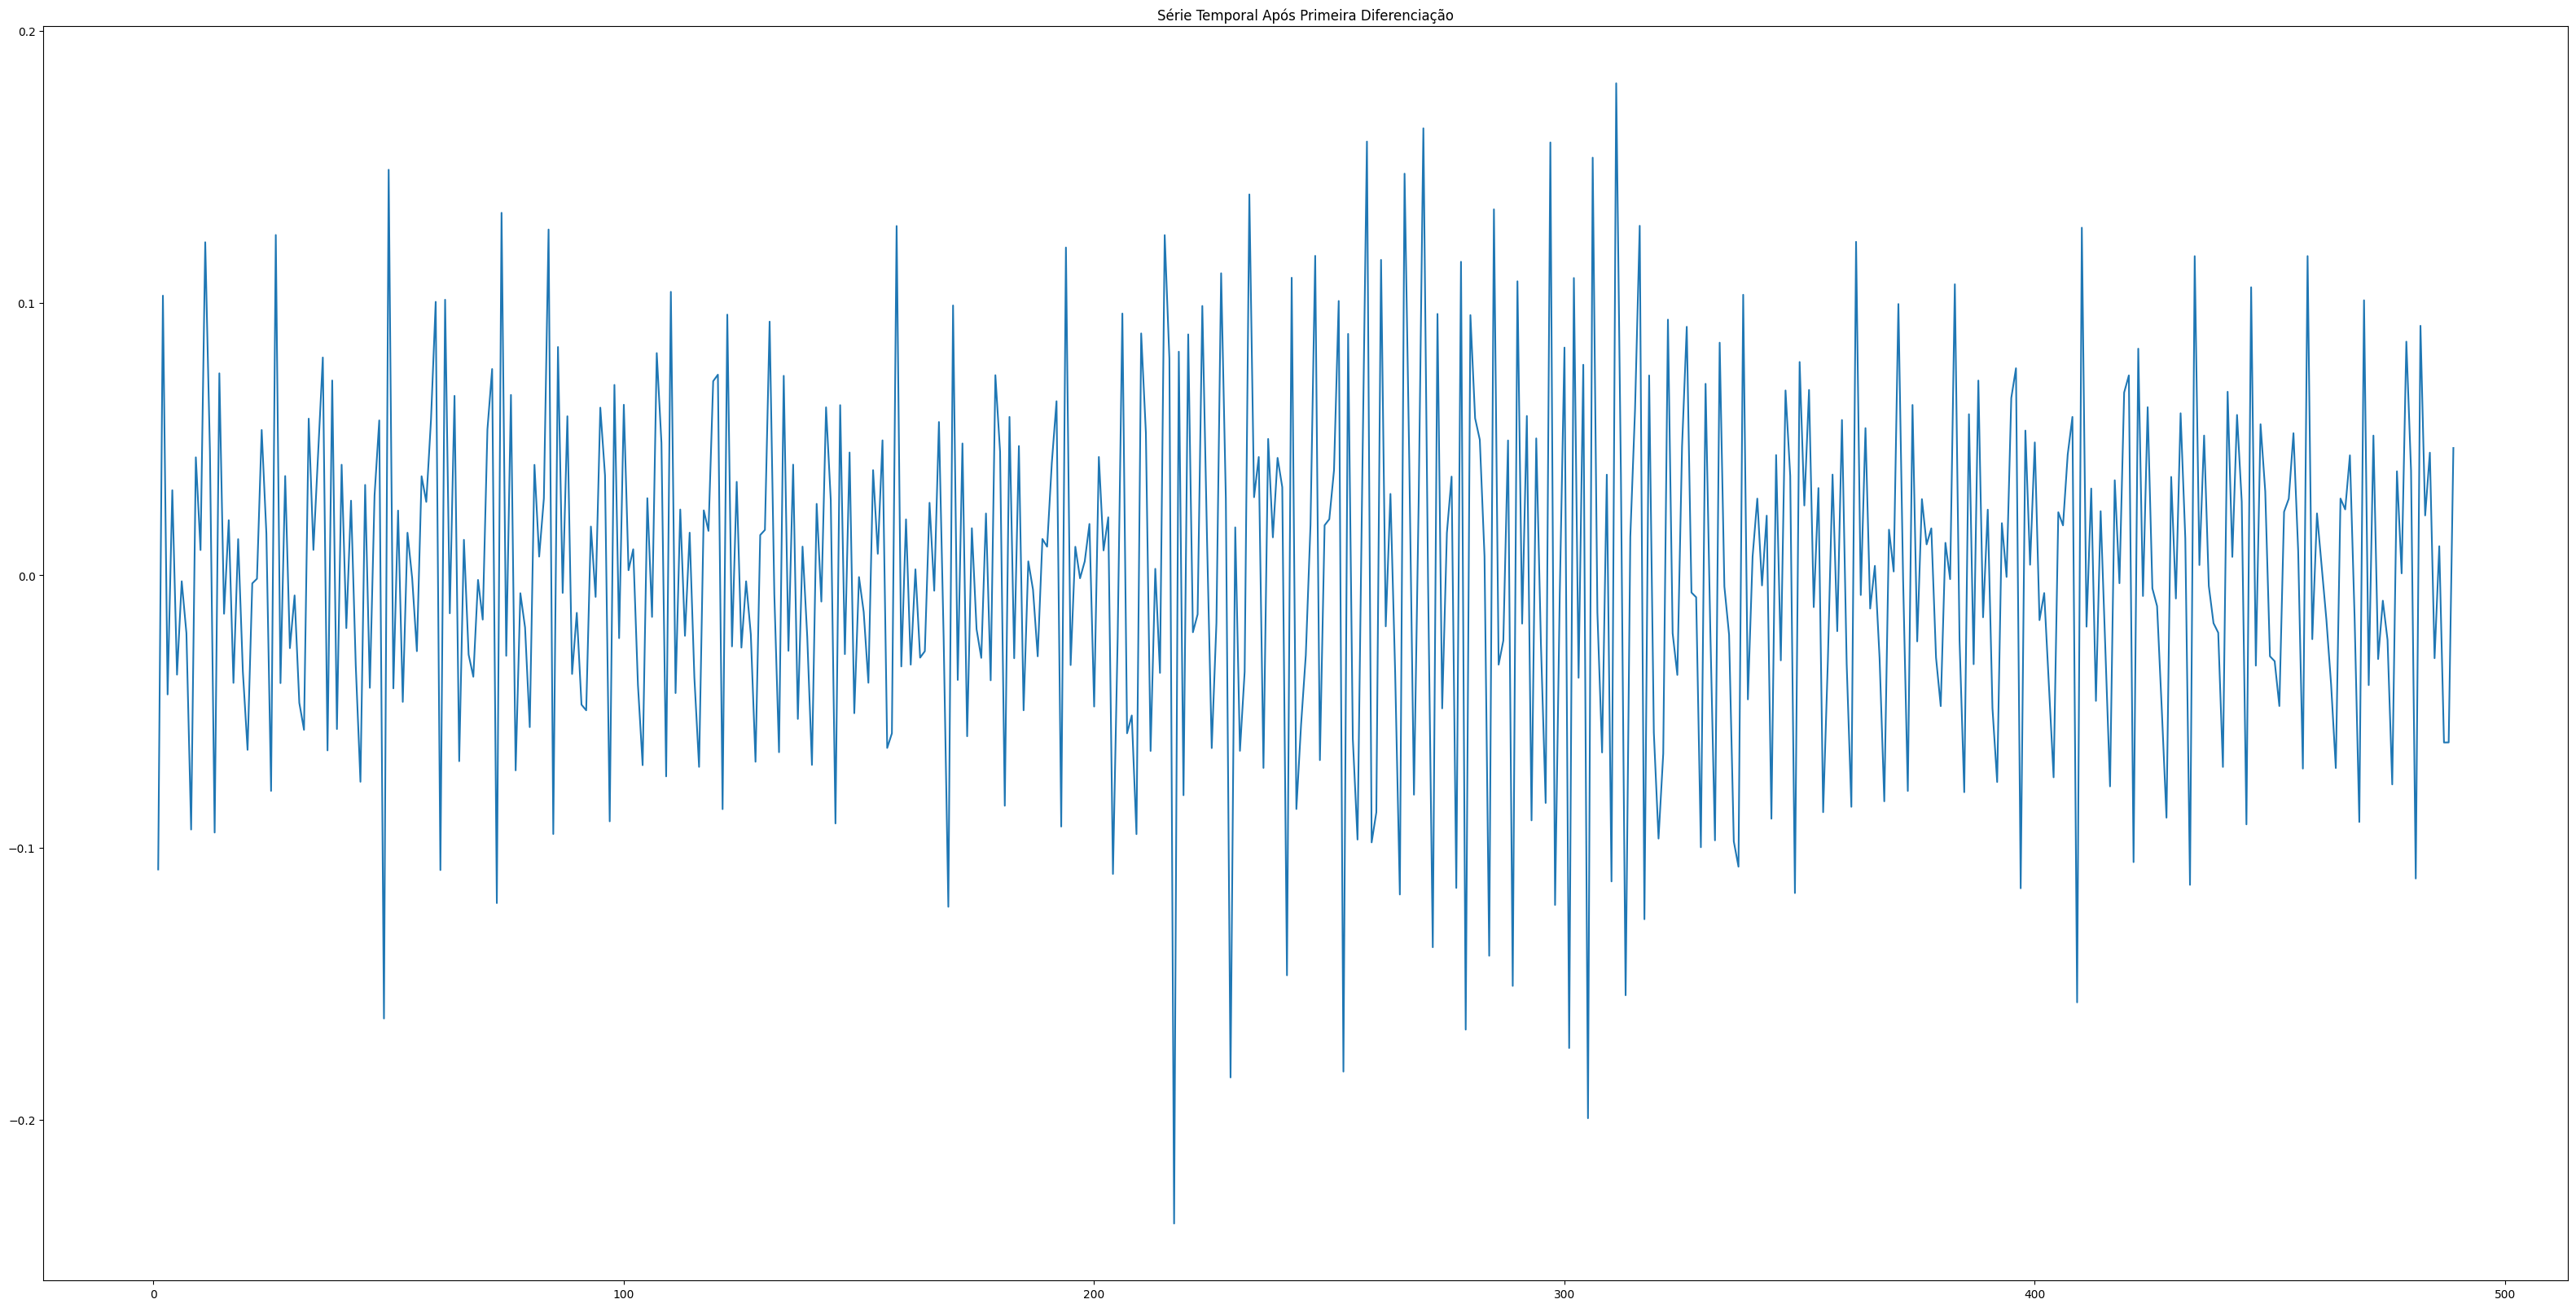

,Year,Month,Day,Total Renewable Energy,Data Time,Log,Diff
1,1973,2,26,197.330,1973-02-26,5.284877,-0.108023
2,1973,3,26,218.687,1973-03-26,5.387641,0.102764
3,1973,4,26,209.330,1973-04-26,5.343912,-0.043730
4,1973,5,26,215.982,1973-05-26,5.375195,0.031283
5,1973,6,26,208.249,1973-06-26,5.338734,-0.036461
...,...,...,...,...,...,...,...
485,2013,6,26,457.129,2013-06-26,6.124966,-0.030415
486,2013,7,26,462.057,2013-07-26,6.135688,0.010723
487,2013,8,26,434.547,2013-08-26,6.074304,-0.061384
488,2013,9,26,408.686,2013-09-26,6.012947,-0.061357


In [5]:
# Aplicar a primeira diferenciação
initial_value = train['Log'].loc[0]
train.loc[:, ['Diff']] = train['Log'].diff().dropna()

# Verificar se há valores NaN ou Inf no DataFrame
print(train['Diff'].isna().sum())  # Contar quantos NaN existem
print((train['Diff'] == np.inf).sum())  # Contar quantos Inf existem

# Remover valores NaN ou Inf
train_cleaned = train['Diff'].replace([np.inf, -np.inf], np.nan).dropna()

# Verifique novamente
print(train_cleaned.isna().sum())  # Agora deve ser 0

# Agora execute o teste ADF
result_diff1 = adfuller(train_cleaned)
print('ADF Statistic:', result_diff1[0])
print('p-value:', result_diff1[1])

# Plotar a série diferenciada
plt.figure(figsize=(40, 20))
plt.plot(train['Diff'])
plt.title('Série Temporal Após Primeira Diferenciação')
plt.show()

train = train.dropna()
train

# train['Diff'] = pd.DataFrame(train['Diff'])

In [6]:
from pmdarima import auto_arima

# Treinando o modelo AutoARIMA nos dados diferenciais
model = auto_arima(train["Diff"].dropna(), 
                   seasonal=True, m=12, 
                   trace=True, error_action="ignore", 
                   suppress_warnings=True)

# Fazendo previsões para o conjunto de teste
forecast = model.predict(n_periods=len(test))

# Reverter a diferenciação
last_value_train_log = train["Log"].iloc[-1]
y_pred_log = [last_value_train_log]

for value in forecast:
    y_pred_log.append(y_pred_log[-1] + value)

y_pred_log = np.array(y_pred_log[1:])  # Removendo o primeiro valor extra

# Reverter a transformação logarítmica
y_pred = np.exp(y_pred_log)

# Exibir previsões
print("Previsões:", y_pred)


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heitor/Área de Trabalho/Gi

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-1711.890, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1247.047, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1583.481, Time=0.14 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1500.378, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1248.847, Time=0.01 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-1505.944, Time=0.74 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-1618.964, Time=0.89 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=-1708.480, Time=3.14 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=-1709.187, Time=2.47 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-1381.799, Time=0.23 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=-1563.199, Time=2.02 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=-1674.919, Time=1.98 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=-1716.438, Time=2.49 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,2)[12] intercept   : AIC=-1718.260, Time=2.63 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=-1710.015, Time=2.08 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=-1717.389, Time=2.19 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-1721.239, Time=0.77 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-1513.571, Time=0.53 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-1620.893, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-1383.091, Time=0.15 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=-1563.036, Time=1.85 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=-1676.891, Time=1.60 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=-1711.489, Time=0.85 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-1714.857, Time=0.74 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,1)[12] intercept   : AIC=-1710.098, Time=1.00 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-1703.723, Time=0.63 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(1,0,1)[12] intercept   : AIC=-1717.090, Time=0.91 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=-1717.223, Time=0.88 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,1)[12] intercept   : AIC=-1716.853, Time=1.03 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12]             : AIC=-1723.508, Time=0.54 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12]             : AIC=-1512.263, Time=0.42 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12]             : AIC=-1622.490, Time=0.21 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,1)[12]             : AIC=-1724.144, Time=5.51 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,0)[12]             : AIC=-1678.691, Time=2.56 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,2)[12]             : AIC=-1720.143, Time=1.46 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,2)[12]             : AIC=-1723.017, Time=1.22 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,1)[12]             : AIC=-1726.855, Time=0.89 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,1)[12]             : AIC=-1725.304, Time=0.38 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,0)[12]             : AIC=-1679.992, Time=0.24 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,2)[12]             : AIC=-1722.012, Time=1.41 sec
 ARIMA(0,0,2)(1,0,0)[12]             : AIC=-1624.482, Time=0.13 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,2)[12]             : AIC=-1726.054, Time=1.06 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,1)[12]             : AIC=-1708.472, Time=1.01 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(2,0,1)[12]             : AIC=-1724.617, Time=1.13 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,1)[12]             : AIC=-1724.995, Time=1.04 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(2,0,1)[12]             : AIC=-1725.532, Time=1.04 sec


/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,1)[12] intercept   : AIC=-1704.104, Time=1.13 sec

Best model:  ARIMA(0,0,2)(2,0,1)[12]          
Total fit time: 54.635 seconds
Previsões: [428.77495203 455.03474978 465.12246021 422.64963997 462.20112908
 459.05615987 478.5362383  470.35118768 472.4436579  454.97487575
 426.94817918 442.85083681 444.18873814 469.88727519 479.06207953
 436.77444625 476.98622972 471.85547048 491.38943103 483.98171099
 485.67844926 469.49816151 440.77386848 456.33219181 457.81311367
 483.75592701 492.90741997 450.10690819 490.93260541 485.44163513
 505.2218819  497.84083708 499.49908758 483.31262239 454.11458615
 469.82409575 471.34538675 497.64786808 506.90585881 463.49614796
 504.92256457 499.31181992 519.36320124 511.89977762 513.5718024
 497.19109097 467.55693263 483.48832526 485.03460786 511.70942823
 521.09144042 477.06553033 519.08388772 513.38972295 533.71239263
 526.15186566 527.84506009 511.2452528  481.18539078 497.34649641
 498.91524975 525.95972621 535.46668405 490.8310607

/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/heitor/Área de Trabalho/Github/neuroevolution/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


RMSE: 31.07
MAE: 24.32
MAPE: 4.86%
R²: 0.2867


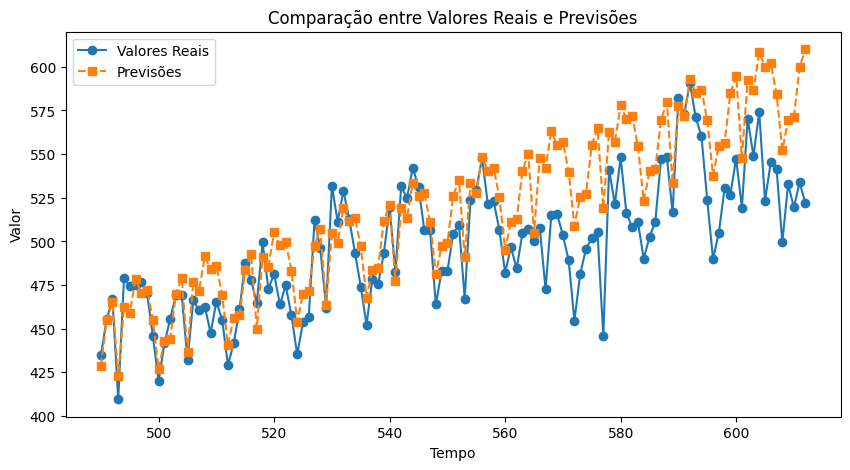

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reverter a diferenciação
last_value_train_log = train["Log"].iloc[-1]
y_pred_log = [last_value_train_log]

for value in forecast:
    y_pred_log.append(y_pred_log[-1] + value)

y_pred_log = np.array(y_pred_log[1:])  # Remover o primeiro valor extra

# Reverter a transformação logarítmica
y_pred = np.exp(y_pred_log)
y_true = test['Total Renewable Energy'].values

# Cálculo das métricas
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Exibir métricas
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot da comparação entre valores reais e previstos
plt.figure(figsize=(10, 5))
plt.plot(test.index, y_true, label="Valores Reais", marker="o")
plt.plot(test.index, y_pred, label="Previsões", linestyle="dashed", marker="s")
plt.legend()
plt.title("Comparação entre Valores Reais e Previsões")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()
